In [18]:
from glob import glob

from astropy.io import fits
from astropy.table import Table, join, vstack, hstack, unique

from desispec.io import read_spectra, write_spectra
from desispec.spectra import stack as specstack
from desispec.spectra import Spectra
from desispec.coaddition import coadd
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution

import redrock.templates

import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [307]:
mpl.rc('font', size=16)
mpl.rc('axes', titlesize='medium')

In [3]:
redux = 'daily/tiles/cumulative'

tiles = sorted(glob('{}/{}/*'.format(os.environ['DESI_SPECTRO_REDUX'], redux)))

sv1tiles = []
sv3tiles = []
for tile in tiles:
    tileid = int(os.path.basename(tile))
    d = sorted(glob('{}/*'.format(tile)))
    if tileid < 20000:
        sv3tiles.append(d[-1])
    if tileid > 80000:
        sv1tiles.append(d[-1]) 

In [4]:
for sv3tile in sv3tiles:
    zbfiles = sorted(glob('{}/zbest*fits'.format(sv3tile)))
    zbest, fibermap = None, None
    
    for zbfile in zbfiles:
        _zbest = Table.read(zbfile, 'ZBEST')
        # Select galaxies and QSOs with a solid redshift.
        select = (_zbest['SPECTYPE'] != 'STAR') & (_zbest['ZWARN']==0) & (_zbest['DELTACHI2']>=25)
        _zbest = _zbest[select]
        
        _fibermap = Table.read(zbfile, 'FIBERMAP')
        idx = np.in1d(_fibermap['TARGETID'], _zbest['TARGETID'])
        n = len(_zbest)
        _fibermap = _fibermap[idx]#[-n:]
        
        if zbest is None or fibermap is None:
            zbest = _zbest
            fibermap = _fibermap
        else:
            zbest = vstack([zbest, _zbest])
            fibermap = vstack([fibermap, _fibermap])
    break

In [5]:
zbfile

'/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/1/20210406/zbest-9-1-thru20210406.fits'

In [6]:
np.unique(zbest['SPECTYPE'], return_counts=True)

(<Column name='SPECTYPE' dtype='bytes6' length=2>
 GALAXY
    QSO,
 array([2059,  734]))

(array([3.940e+02, 1.498e+03, 5.170e+02, 2.240e+02, 1.120e+02, 3.200e+01,
        9.000e+00, 2.000e+00, 1.000e+00, 4.000e+00]),
 array([-2.77298439e-03,  5.60855766e-01,  1.12448452e+00,  1.68811327e+00,
         2.25174202e+00,  2.81537077e+00,  3.37899952e+00,  3.94262827e+00,
         4.50625702e+00,  5.06988577e+00,  5.63351452e+00]),
 <a list of 10 Patch objects>)

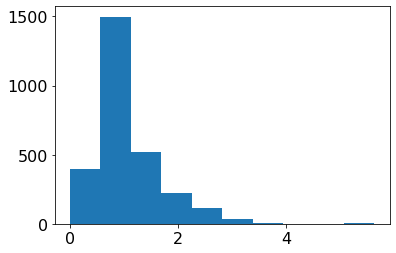

In [7]:
plt.hist(zbest['Z'])

In [8]:
fibermap

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,EXPTIME,PSF_TO_FIBER_SPECFLUX,NIGHT,EXPID,MJD,TILEID
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32
39627817436058850,0,311,311,0,0,149.7272614861328,1.1361875315919674,0.0,0.0,2015.5,5400.0,2162697,1,TGT,78.097435,-285.9366,103200,0.32719911458555384,1,9010,338166,5346,DEV,1.6936976,6.080918,18.7367,264.5119,55.56353,10.075568,0,0,,0.0,0.0,0.0,0.0,1496p012,0.026749652,51.989223,29.48612,1.5687406,0.41309118,0.43432325,1.5593599,4.8047447,0.43432325,1.5593599,4.8047447,4.0,1.8740429,0.028569974,-0.25228384,S,103200,9,2162697,0,0,0,0,0,0,2,78.074,-285.884,0.001,0.004,149.72726569348964,1.136172055230268,860.625,0.7408258020960352,20210406,83714,59311.13373053,1
39627823484241158,0,156,156,3,0,150.05897874058275,1.390858241986411,0.0,0.0,2015.5,5400.0,1441862,1,TGT,-4.432202,-220.39124,103400,0.3855304827905608,1,9010,339608,1286,PSF,0.52967143,0.7079924,1.3805336,1681.7052,679.724,124.54396,0,0,,0.0,0.0,0.0,0.0,1501p015,0.020432826,1.9581124,2.630761,3.1587098,0.66002655,0.41200817,0.5507162,1.0738565,0.41200817,0.5507162,1.0738565,0.0,0.0,0.0,0.0,S,103400,9,1441862,0,0,0,0,0,0,2,-4.44,-220.351,0.003,0.005,150.05899093745177,1.3908384370013196,860.625,0.7889999999999998,20210406,83714,59311.13373053,1
39627817444444591,0,198,198,4,0,150.10621596106574,1.2461080452085396,0.0,0.0,2015.5,5400.0,2162697,1,TGT,-16.097828,-257.25854,103200,0.3020414510386349,1,9010,338168,2479,REX,0.119131096,0.94949,5.7996683,729.6087,234.43576,39.360733,0,0,,0.0,0.0,0.0,0.0,1501p012,0.020795267,29.114927,13.468876,2.5731223,0.6605551,0.063151665,0.50332683,3.0744176,0.063151665,0.50332683,3.0744176,1.0,0.47237855,0.0,0.0,S,103200,9,2162697,0,0,0,0,0,0,2,-16.096,-257.199,-0.005,-0.001,150.10619574966944,1.2461118942819864,860.625,0.7758176748091931,20210406,83714,59311.13373053,1
39627817440253464,0,233,233,6,0,149.99937172274898,1.2148894584603889,0.0,0.0,2015.5,5400.0,2162697,1,TGT,10.347199,-265.23273,103200,0.8146982641322258,1,9010,338167,5656,DEV,1.7538317,9.898755,32.20129,306.78214,82.94422,13.8481045,0,0,,0.0,0.0,0.0,0.0,1498p012,0.01963397,79.01,42.423904,1.4428372,0.4292783,0.45340723,2.5590637,8.3248,0.45814615,2.5759053,8.358324,4.0,1.5136857,0.0019198876,-0.030605955,S,103200,9,2162697,0,0,0,0,0,0,2,10.337,-265.173,0.002,-0.002,149.9993797818193,1.2148972544944971,860.625,0.7494952819461834,20210406,83714,59311.13373053,1
39627823480049888,0,172,172,7,0,149.97432537384907,1.3775229127809734,0.0,0.0,2015.5,5400.0,1152921504609009673,1,TGT,16.415714,-223.75594,103200,0.4089739044326226,517,9010,339607,4320,SER,5.208796,21.604393,52.04003,312.568,78.16317,16.462551,0,0,,0.0,0.0,0.0,0.0,1498p015,0.020600462,109.77654,79.721825,1.4107361,0.42453632,1.5232027,6.3177495,15.218011,1.5232027,6.3177495,15.218011,3.188

(array([  48.,  207.,  498.,  825., 1332., 1776., 2211., 1389.,   75.,
           3.]),
 array([17.557943, 18.330336, 19.102728, 19.87512 , 20.647512, 21.419905,
        22.192297, 22.96469 , 23.737082, 24.509474, 25.281866],
       dtype=float32),
 <a list of 10 Patch objects>)

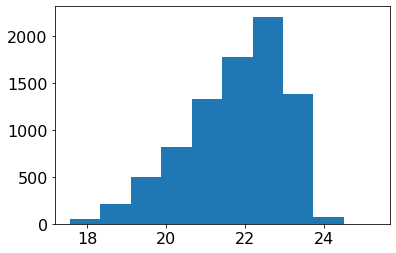

In [9]:
select = fibermap['FLUX_R'] > 0
r = 22.5 - 2.5*np.log10(fibermap['FLUX_R'][select])
plt.hist(r)

In [10]:
# Select pairs of galaxies and QSOs.
pairs = np.random.choice(zbest['TARGETID'], [int(0.05*len(zbest)), 2], replace=False)

# Loop through pairs of TARGETIDs.
zlentab, zbkgtab, zjointab = None, None, None

for pair in pairs:
    # Check the fibermap table to ensure the exposure times of the lens and background are equal.
    # Unequal total exposure times could occur if a petal or a CANBus was disabled during one exposure. 
    select0 = np.in1d(fibermap['TARGETID'], pair[0])
    select1 = np.in1d(fibermap['TARGETID'], pair[1])
    i, j = np.where(select0)[0], np.where(select1)[0]
    exptime0, exptime1 = [np.sum(fibermap[_]['EXPTIME']) for _ in (i,j)]
    if exptime0 != exptime1:
        continue
    
    # Sort to make index k the "lens" and index l the "background" galaxy.
    select = np.in1d(zbest['TARGETID'], pair)
    pairdata = zbest[select]
    k, l = np.where(select)[0] if pairdata[0]['Z'] < pairdata[1]['Z'] else np.where(select)[0][::-1]
    
    # Then join the two ZBEST table entries into one row.
    row = join(zbest[k], zbest[l], join_type='cartesian')
    
    # Generate a random number giving the relative contribution of objects 1 and 2.
    alpha = np.random.uniform(0.1, 0.9)
    row['ALPHA'] = alpha
    
    # Accumulate the rows of pairs of "lenses" and "background" galaxies.
    if zjointab is None:
        zjointab = row
        zlentab = zbest[k]
        zbkgtab = zbest[l]
    else:
        zjointab = vstack([zjointab, row])
        zlentab = vstack([zlentab, zbest[k]])
        zbkgtab = vstack([zbkgtab, zbest[l]])

In [11]:
i = np.in1d(fibermap['TARGETID'], zlentab['TARGETID'])
lentab = unique(fibermap[i]['TARGETID', 'TILEID', 'PETAL_LOC'])

i = np.in1d(fibermap['TARGETID'], zbkgtab['TARGETID'])
bkgtab = unique(fibermap[i]['TARGETID', 'TILEID', 'PETAL_LOC'])

In [266]:
templates = dict()
for f in redrock.templates.find_templates():
    t = redrock.templates.Template(f)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [277]:
tile = lentab['TILEID'][0]
tilefolder = sorted(glob('{}/{}/{}/*'.format(os.environ['DESI_SPECTRO_REDUX'], redux, tile)))[-1]

lenspec = None

for petal in np.unique(lentab['PETAL_LOC']):
    coadd_file = glob('{}/coadd-{}*.fits'.format(tilefolder, petal))[0]
    coadds = read_spectra(coadd_file)
    
    # Extract selected spectra from this petal.
    targetids = lentab[lentab['PETAL_LOC'] == petal]['TARGETID']
    i = np.in1d(coadds.fibermap['TARGETID'], targetids)
    coadds = coadds[i]
    
    if lenspec is None:
        lenspec = coadds
    else:
        lenspec = specstack([lenspec, coadds])
        
# Unscramble the indices so the order of the spectra matches our coadd...
idx = np.nonzero(zlentab['TARGETID'][:,None] == lenspec.fibermap['TARGETID'])[1]
lenspec = lenspec[idx]
lenspec.extra_catalog = zlentab

# Compute and store model fluxes from redrock.
lenspec.extra = {}
for band in 'brz':
    model = []
    
    for i in range(lenspec.num_spectra()):
        # Get the redrock best fit model for the lens.
        z = lenspec.extra_catalog[i]['Z']
        sp, sb = lenspec.extra_catalog[i]['SPECTYPE'], lenspec.extra_catalog[i]['SUBTYPE']
        ncoeff = templates[(sp, sb)].flux.shape[0]
        coeff = lenspec.extra_catalog[i]['COEFF'][0:ncoeff]
        tflux = templates[(sp, sb)].flux.T.dot(coeff)
        twave = templates[(sp, sb)].wave * (1 + z)
        
        R = Resolution(lenspec.resolution_data[band][i])
        txflux = R.dot(resample_flux(lenspec.wave[band], twave, tflux))
        model.append(txflux)
    
    lenspec.extra[band] = { 'model' : np.asarray(model) }

# Turn off scores.
if not hasattr(lenspec, 'scores_comments'):
    lenspec.scores_comments = None

INFO:spectra.py:253:read_spectra: iotime 0.418 sec to read coadd-0-1-thru20210406.fits at 2021-06-15T04:23:02.054125
INFO:spectra.py:253:read_spectra: iotime 0.437 sec to read coadd-1-1-thru20210406.fits at 2021-06-15T04:23:02.906018
INFO:spectra.py:253:read_spectra: iotime 0.448 sec to read coadd-2-1-thru20210406.fits at 2021-06-15T04:23:03.804892
INFO:spectra.py:253:read_spectra: iotime 0.415 sec to read coadd-3-1-thru20210406.fits at 2021-06-15T04:23:04.656877
INFO:spectra.py:253:read_spectra: iotime 0.431 sec to read coadd-4-1-thru20210406.fits at 2021-06-15T04:23:05.549101
INFO:spectra.py:253:read_spectra: iotime 0.614 sec to read coadd-5-1-thru20210406.fits at 2021-06-15T04:23:06.653541
INFO:spectra.py:253:read_spectra: iotime 0.419 sec to read coadd-6-1-thru20210406.fits at 2021-06-15T04:23:07.574802
INFO:spectra.py:253:read_spectra: iotime 0.437 sec to read coadd-8-1-thru20210406.fits at 2021-06-15T04:23:08.547629
INFO:spectra.py:253:read_spectra: iotime 0.403 sec to read coadd

In [278]:
tile = bkgtab['TILEID'][0]
tilefolder = sorted(glob('{}/{}/{}/*'.format(os.environ['DESI_SPECTRO_REDUX'], redux, tile)))[-1]

bkgspec = None

for petal in np.unique(bkgtab['PETAL_LOC']):
    coadd_file = glob('{}/coadd-{}*.fits'.format(tilefolder, petal))[0]
    coadds = read_spectra(coadd_file)
    
    # Extract selected spectra from this petal.
    targetids = bkgtab[bkgtab['PETAL_LOC'] == petal]['TARGETID']
    i = np.in1d(coadds.fibermap['TARGETID'], targetids)
    coadds = coadds[i]
    
    if bkgspec is None:
        bkgspec = coadds
    else:
        bkgspec = specstack([bkgspec, coadds])
        
# Unscramble the indices so the order of the spectra matches our coadd...
idx = np.nonzero(zbkgtab['TARGETID'][:,None] == bkgspec.fibermap['TARGETID'])[1]
bkgspec = bkgspec[idx]
bkgspec.extra_catalog = zbkgtab

# Compute and store model fluxes from redrock.
bkgspec.extra = {}
for band in 'brz':
    model = []
    
    for i in range(bkgspec.num_spectra()):
        # Get the redrock best fit model for the lens.
        z = bkgspec.extra_catalog[i]['Z']
        sp, sb = bkgspec.extra_catalog[i]['SPECTYPE'], bkgspec.extra_catalog[i]['SUBTYPE']
        ncoeff = templates[(sp, sb)].flux.shape[0]
        coeff = bkgspec.extra_catalog[i]['COEFF'][0:ncoeff]
        tflux = templates[(sp, sb)].flux.T.dot(coeff)
        twave = templates[(sp, sb)].wave * (1 + z)
        
        R = Resolution(bkgspec.resolution_data[band][i])
        txflux = R.dot(resample_flux(bkgspec.wave[band], twave, tflux))
        model.append(txflux)
    
    bkgspec.extra[band] = {'model' : np.asarray(model)}

# Turn off scores.
if not hasattr(bkgspec, 'scores_comments'):
    bkgspec.scores_comments = None

INFO:spectra.py:253:read_spectra: iotime 0.394 sec to read coadd-0-1-thru20210406.fits at 2021-06-15T04:23:11.512144
INFO:spectra.py:253:read_spectra: iotime 0.404 sec to read coadd-1-1-thru20210406.fits at 2021-06-15T04:23:12.350159
INFO:spectra.py:253:read_spectra: iotime 0.465 sec to read coadd-2-1-thru20210406.fits at 2021-06-15T04:23:13.256225
INFO:spectra.py:253:read_spectra: iotime 0.434 sec to read coadd-3-1-thru20210406.fits at 2021-06-15T04:23:14.194291
INFO:spectra.py:253:read_spectra: iotime 0.412 sec to read coadd-4-1-thru20210406.fits at 2021-06-15T04:23:15.069502
INFO:spectra.py:253:read_spectra: iotime 0.428 sec to read coadd-5-1-thru20210406.fits at 2021-06-15T04:23:15.959870
INFO:spectra.py:253:read_spectra: iotime 0.420 sec to read coadd-6-1-thru20210406.fits at 2021-06-15T04:23:16.836387
INFO:spectra.py:253:read_spectra: iotime 0.429 sec to read coadd-8-1-thru20210406.fits at 2021-06-15T04:23:17.720421
INFO:spectra.py:253:read_spectra: iotime 0.407 sec to read coadd

In [279]:
write_spectra('tile{:06d}_lens_spectra.fits'.format(tile), lenspec)
write_spectra('tile{:06d}_bkgd_spectra.fits'.format(tile), bkgspec)

INFO:spectra.py:154:write_spectra: iotime 0.546 sec to write tile000001_lens_spectra.fits at 2021-06-15T04:23:20.808742
INFO:spectra.py:154:write_spectra: iotime 0.525 sec to write tile000001_bkgd_spectra.fits at 2021-06-15T04:23:21.474720


'/global/u2/s/sybenzvi/desi/stronglens/doc/nb/tile000001_bkgd_spectra.fits'

In [315]:
bands = []
wave = {} 
flux = {}
ivar = {}
mask = {}
fibermap = None
extra_catalog=None
    
for band in 'brz':
    f1, w1 = lenspec.flux[band], lenspec.ivar[band]
    m1 = []
    f2, w2 = bkgspec.flux[band], bkgspec.ivar[band]
    m2 = []
    alpha = zjointab['ALPHA'][:,None]
    w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)
    
#     for i in range(lenspec.num_spectra()):
#         # Get the redrock best fit model for the lens.
#         z = lenspec.extra_catalog[i]['Z']
#         sp, sb = lenspec.extra_catalog[i]['SPECTYPE'], lenspec.extra_catalog[i]['SUBTYPE']
#         ncoeff = templates[(sp, sb)].flux.shape[0]
#         coeff = lenspec.extra_catalog[i]['COEFF'][0:ncoeff]
#         tflux = templates[(sp, sb)].flux.T.dot(coeff)
#         twave = templates[(sp, sb)].wave * (1 + z)
        
#         R = Resolution(lenspec.resolution_data[band][i])
#         txflux = R.dot(resample_flux(lenspec.wave[band], twave, tflux))
#         m1.append(txflux)
        
#         # Get the redrock best fit model for the background galaxy.
#         z = bkgspec.extra_catalog[i]['Z']
#         sp, sb = bkgspec.extra_catalog[i]['SPECTYPE'], bkgspec.extra_catalog[i]['SUBTYPE']
#         ncoeff = templates[(sp, sb)].flux.shape[0]
#         coeff = bkgspec.extra_catalog[i]['COEFF'][0:ncoeff]
#         tflux = templates[(sp, sb)].flux.T.dot(coeff)
#         twave = templates[(sp, sb)].wave * (1 + z)
        
#         R = Resolution(bkgspec.resolution_data[band][i])
#         txflux = R.dot(resample_flux(bkgspec.wave[band], twave, tflux))
#         m2.append(txflux)
    
    # Add the models using the alpha parameter to tune the relative contribution of the lens and background object.
    m1 = lenspec.extra[band]['model']
    m2 = bkgspec.extra[band]['model']
#     m1 = np.asarray(m1)    
#     m2 = np.asarray(m2)
    m3 = alpha*m1 + (1-alpha)*m2

    n3 = np.sqrt(alpha*(f1-m1)**2 + (1-alpha)*(f2-m2)**2)
    f3 = m3
#     f3 = np.random.normal(loc=m3, scale=1./np.sqrt(w3))
    f3 = np.random.normal(loc=m3, scale=n3)
    
    # Set up the spectrum wavelength, flux, variance, mask, bands.
    wave[band] = lenspec.wave[band]
    flux[band] = f3
    ivar[band] = w3
    mask[band] = lenspec.mask[band] | bkgspec.mask[band]
    bands.append(band)

# Set up the fibermap as a join of the lens and background fibermaps.
for row1, row2 in zip(lenspec.fibermap, bkgspec.fibermap):
    newrow = join(row1, row2, join_type='cartesian')
    if fibermap is None:
        fibermap = newrow
    else:
        fibermap = vstack([fibermap, newrow])
        
# Add redshift info from the two individual spectra as an extra catalog.
extra_catalog = zjointab

newspec = Spectra(bands, wave, flux, ivar, mask, fibermap=fibermap, extra_catalog=extra_catalog)

In [316]:
write_spectra('tile{:06d}_simlens_spectra.fits'.format(tile), newspec)

INFO:spectra.py:154:write_spectra: iotime 0.201 sec to write tile000001_simlens_spectra.fits at 2021-06-15T04:35:22.629894


'/global/u2/s/sybenzvi/desi/stronglens/doc/nb/tile000001_simlens_spectra.fits'

In [317]:
x = read_spectra('tile000001_simlens_spectra.fits')

INFO:spectra.py:253:read_spectra: iotime 0.130 sec to read tile000001_simlens_spectra.fits at 2021-06-15T04:35:24.256611


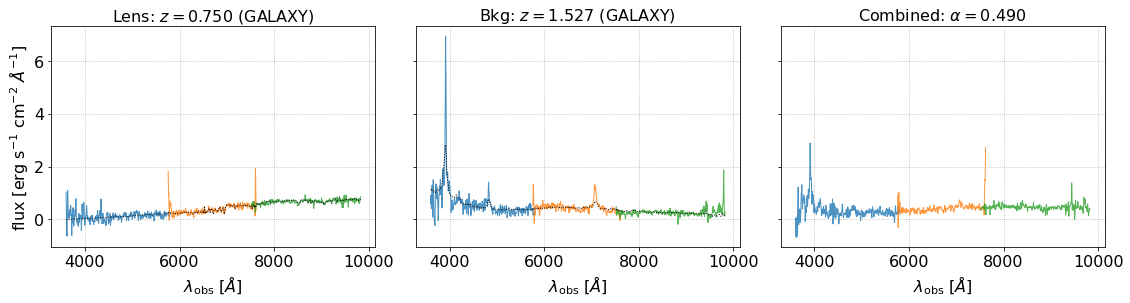

In [318]:
from scipy.ndimage import gaussian_filter1d

fig, axes = plt.subplots(1,3, figsize=(16,4.5), sharex=True, sharey=True, tight_layout=True)

j = 18
for b in 'brz':
    ax = axes[0]
    smoothed = gaussian_filter1d(lenspec.flux[b][j], 5)
    ax.plot(lenspec.wave[b], smoothed, lw=1, alpha=0.8)
    smoothed = gaussian_filter1d(lenspec.extra[b]['model'][j], 5)
    ax.plot(bkgspec.wave[b], smoothed, lw=1, color='k', ls=':')
    ax.set(title='Lens: $z={:.3f}$ ({})'.format(lenspec.extra_catalog[j]['Z'], lenspec.extra_catalog[j]['SPECTYPE']),
           xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
           ylabel=r'flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
    ax.grid(ls=':')
    
    ax = axes[1]
    smoothed = gaussian_filter1d(bkgspec.flux[b][j], 5)
    ax.plot(bkgspec.wave[b], smoothed, lw=1, alpha=0.8)
    smoothed = gaussian_filter1d(bkgspec.extra[b]['model'][j], 5)
    ax.plot(bkgspec.wave[b], smoothed, lw=1, color='k', ls=':')
    ax.set(title='Bkg: $z={:.3f}$ ({})'.format(bkgspec.extra_catalog[j]['Z'], lenspec.extra_catalog[j]['SPECTYPE']),
           xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')
    ax.grid(ls=':')
    
    ax = axes[2]
    smoothed = gaussian_filter1d(newspec.flux[b][j], 5)
    ax.plot(newspec.wave[b], smoothed, lw=1, alpha=0.8)
    ax.set(title=r'Combined: $\alpha={:.3f}$'.format(newspec.extra_catalog['ALPHA'][j]),
           xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')
    ax.grid(ls=':')

In [304]:
newspec.extra_catalog['ALPHA'][7]

0.6361113315458831